# Challenge
The idea behind this challenge is for you to explore the dataset, build a prediction model from it and then code a Python module that serves the model. Therefore there will be two main parts:

1. Your Jupyter (IPython) notebook containing all your experiments, analyzes, and results. In this notebook, you will perform all your visualizations, data normalizations, training and evaluation of your model.
2. A complete Python module ready to be used containing the model you trained. This module should be coded as if the engineering team would use it so it must contain usage instructions and a clear interface (generally speaking) to access your model.

## The dataset
Kickstarter is one of the main online crowdfunding platforms in the world. The dataset provided contains more de 300,000 projects launched on the platform in 2018. In the `data.csv` file there are the following columns:

- **ID**: internal ID, _numeric_
- **name**: name of the project, _string_
- **category**: project's category, _string_
- **main_category**: campaign's category, _string_
- **currency**: project's currency, _string_
- **deadline**: project's deadline date, _timestamp_
- **goal**: fundraising goal, _numeric_
- **launched**: project's start date, _timestamp_
- **pledged**: amount pledged by backers (project's currency), _numeric_
- **state**: project's current state, _string_; **this is what you have to predict**
- **backers**: amount of poeple that backed the project, _numeric_
- **country**: project's country, _string_
- **usd pledged**: amount pledged by backers converted to USD (conversion made by KS), _numeric_
- **usd_pledged_real**: amount pledged by backers converted to USD (conversion made by fixer.io api), _numeric_
- **usd_goal_real**: fundraising goal is USD, _numeric_

## Goal
Your goal is to predict whether a project will be successful or not. It is entirely up to you which features you will use and which model. When it comes to performance metrics you should be able to say when the model is good enough. There are no minimum requirements or tricky conditions. What we are trying to evaluate is how you handle an unknown dataset in a classification task and your ability to deliver the results.

## Deliverables
Do not use this notebook for your submission. The expected outputs are:

1. A Jupyter (IPython) notebook (that you have to create) containing your work and explanations. This is where you will put all your experiments, notes, visualizations and transformations in the data. This is also where you will prepare your data and train your prediction model.
2. A Python module containing your model and functions to use to predict Kickstarter projects' state. Assume that in order to review your work an engineer will import this module and try to make some predictions so your model should be in it.
3. A Markdown file containing usage instructions for your Python module. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import datetime as dt

%matplotlib inline

In [2]:
data = pd.read_csv('data.csv')

# Get to know data

In [3]:
data.head(5)

ID                                               name  \
0  1000002330                    The Songs of Adelaide & Abullah   
1  1000003930      Greeting From Earth: ZGAC Arts Capsule For ET   
2  1000004038                                     Where is Hank?   
3  1000007540  ToshiCapital Rekordz Needs Help to Complete Album   
4  1000011046  Community Film Project: The Art of Neighborhoo...   

         category main_category currency    deadline     goal  \
0          Poetry    Publishing      GBP  2015-10-09   1000.0   
1  Narrative Film  Film & Video      USD  2017-11-01  30000.0   
2  Narrative Film  Film & Video      USD  2013-02-26  45000.0   
3           Music         Music      USD  2012-04-16   5000.0   
4    Film & Video  Film & Video      USD  2015-08-29  19500.0   

              launched  pledged     state  backers country  usd pledged  \
0  2015-08-11 12:12:28      0.0    failed        0      GB          0.0   
1  2017-09-02 04:43:57   2421.0    failed       15      US        100.0   
2  2013-01-12 00:20:50    220.0    failed        3      US        220.0   
3  2012-03-17 03:24:11      1.0    failed        1      US          1.0   
4  2015-07-04 08:35:03   1283.0  canceled       14      US       1283.0   

   usd_pledged_real  usd_goal_real  
0               0.0        1533.95  
1            2421.0       30000.00  
2             220.0       45000.00  
3               1.0        5000.00  
4            1283.0       19500.00

In [4]:
print("Number of projects in dataset: ", len(data['name']) )

Number of projects in dataset:  378661


In [5]:
#distribution of our response variable.
data['state'].value_counts().plot(kind = 'bar')

Here we are concerned only about whether a project succeeded or failed and thus we will remove rest of the data

In [6]:
filtered_data = data[(data.state == 'failed') | (data.state == 'successful')]
filtered_data['state'].value_counts().plot(kind = 'bar')

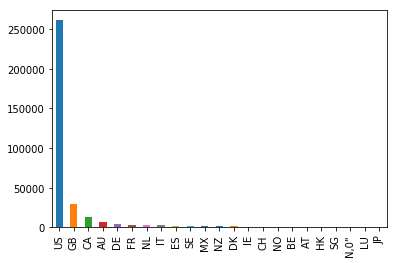

In [7]:
filtered_data['country'].value_counts().plot(kind = 'bar')

In [8]:
filtered_data['currency'].value_counts().plot(kind = 'bar')

These plots concludes that most of projects are from US and in USD.

In [9]:
print('Total number of categories: ', len(filtered_data.category.unique()))

Total number of categories:  159


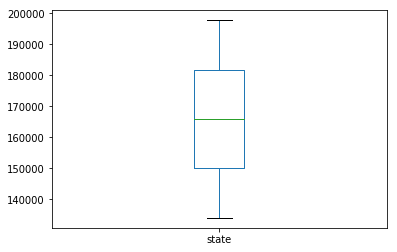

In [10]:
filtered_data.state.value_counts().plot(kind = 'box')

## Data Pre-processing

We will add a new derived feature which is describe the time to complete the project. This is simple difference between launch date and deadline. This will give a of days to work on a project an complete it. 

In [11]:
filtered_data['deadline'] = pd.to_datetime(filtered_data['deadline'])
filtered_data['launched'] = pd.to_datetime(filtered_data['launched'])
filtered_data['date_diff'] = filtered_data['deadline'].sub(filtered_data['launched'], axis = 0) 
filtered_data['date_diff'] = filtered_data['date_diff'].astype(dt.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)

C:\Anaconda1\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Anaconda1\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda1\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

In [12]:
# drop deadline and launched date
filtered_data.drop(['deadline', 'launched'], axis = 1, inplace = True)

C:\Anaconda1\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [13]:
# Handle null values in data
filtered_data['usd pledged'] = filtered_data['usd pledged'].fillna(filtered_data['usd_pledged_real'])

C:\Anaconda1\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
filtered_data['state'] = filtered_data.state.str.contains('successful').astype(int)

C:\Anaconda1\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
filtered_data.drop(['ID', 'name','category'], axis = 1, inplace = True)
filtered_data.head()

C:\Anaconda1\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


main_category currency     goal  pledged  state  backers country  \
0    Publishing      GBP   1000.0      0.0      0        0      GB   
1  Film & Video      USD  30000.0   2421.0      0       15      US   
2  Film & Video      USD  45000.0    220.0      0        3      US   
3         Music      USD   5000.0      1.0      0        1      US   
5          Food      USD  50000.0  52375.0      1      224      US   

   usd pledged  usd_pledged_real  usd_goal_real  date_diff  
0          0.0               0.0        1533.95         58  
1        100.0            2421.0       30000.00         59  
2        220.0             220.0       45000.00         44  
3          1.0               1.0        5000.00         29  
5      52375.0           52375.0       50000.00         34

In [16]:
# Check for null data
print('\n Null values in dataset: ')
filtered_data.isnull().sum()


 Null values in dataset: 


main_category       0
currency            0
goal                0
pledged             0
state               0
backers             0
country             0
usd pledged         0
usd_pledged_real    0
usd_goal_real       0
date_diff           0
dtype: int64

## Feature Selection

In [17]:
df = filtered_data

In [18]:
df['main_category'] = df['main_category'].astype('category')
df['currency'] = df['currency'].astype('category')
df['country'] = df['country'].astype('category')

C:\Anaconda1\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Anaconda1\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda1\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

In [19]:
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

C:\Anaconda1\lib\site-packages\pandas\core\frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [20]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 18)
rfe = rfe.fit(df.loc[:, df.columns != 'state'], df['state'] )
#rfe = rfe.fit(X, y )
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1]


In [21]:
import statsmodels.api as sm
logit_model=sm.Logit(df['state'],df.loc[:, (df.columns != 'state')])  
#logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.005740
         Iterations 26
                           Logit Regression Results                           
Dep. Variable:                  state   No. Observations:               331675
Model:                          Logit   Df Residuals:                   331665
Method:                           MLE   Df Model:                            9
Date:                Mon, 13 Aug 2018   Pseudo R-squ.:                  0.9915
Time:                        16:19:25   Log-Likelihood:                -1903.9
converged:                       True   LL-Null:                   -2.2373e+05
                                        LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
main_category        0.0511      0.010      5.154      0.000       0.032       0.071
currency  

The p-values for most of the variables are smaller than 0.05, therefore, most of them are significant to the model. <br/>
p-value for currency and country are comparatively high becasuse thee data is not distributed evenly. Most of the projects are from US and in USD currency. This makes our model bad for projects outside US.

In [22]:
# Coonvert Categorical to numeric.
cat_vars=['main_category','currency','country']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=filtered_data.join(cat_list)
    filtered_data=data1
data_vars=filtered_data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [23]:
data_final=filtered_data[to_keep]
data_final.columns.values

array(['goal', 'pledged', 'state', 'backers', 'usd pledged',
       'usd_pledged_real', 'usd_goal_real', 'date_diff',
       'main_category_Art', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance',
       'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'currency_AUD', 'currency_CAD',
       'currency_CHF', 'currency_DKK', 'currency_EUR', 'currency_GBP',
       'currency_HKD', 'currency_JPY', 'currency_MXN', 'currency_NOK',
       'currency_NZD', 'currency_SEK', 'currency_SGD', 'currency_USD',
       'country_AT', 'country_AU', 'country_BE', 'country_CA',
       'country_CH', 'country_DE', 'country_DK', 'country_ES',
       'country_FR', 'country_GB', 'country_HK', 'country_IE',
       'country

In [24]:
data_final.head(5)

goal  pledged  state  backers  usd pledged  usd_pledged_real  \
0   1000.0      0.0      0        0          0.0               0.0   
1  30000.0   2421.0      0       15        100.0            2421.0   
2  45000.0    220.0      0        3        220.0             220.0   
3   5000.0      1.0      0        1          1.0               1.0   
5  50000.0  52375.0      1      224      52375.0           52375.0   

   usd_goal_real  date_diff  main_category_Art  main_category_Comics  \
0        1533.95         58                  0                     0   
1       30000.00         59                  0                     0   
2       45000.00         44                  0                     0   
3        5000.00         29                  0                     0   
5       50000.00         34                  0                     0   

      ...      country_JP  country_LU  country_MX  country_N,0"  country_NL  \
0     ...               0           0           0             0           0   
1     ...               0           0           0             0           0   
2     ...               0           0           0             0           0   
3     ...               0           0           0             0           0   
5     ...               0           0           0             0           0   

   country_NO  country_NZ  country_SE  country_SG  country_US  
0           0           0           0           0           0  
1           0           0           0           0           1  
2           0           0           0           0           1  
3           0           0           0           0           1  
5           0           0           0           0           1  

[5 rows x 60 columns]

In [25]:
from sklearn.model_selection import train_test_split

#X = filtered_data.drop(['state'], axis=1)
X = filtered_data.drop(['main_category', 'currency','country', 'state','usd pledged'], axis=1)
y = filtered_data['state']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
y_pred = logreg.predict(X_test)

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [29]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.9789453584314041


### What features contribute to successfulness?

In [30]:
from_largest = np.argsort(logreg.coef_)[0][::-1]
positive_coef_inds = []
for index in from_largest:
    if logreg.coef_[0][index] > 0:
        positive_coef_inds.append(index)
    else:
        break
print(X_train.iloc[:, positive_coef_inds].columns)

Index(['usd_pledged_real', 'pledged', 'date_diff', 'backers', 'currency_USD',
       'country_US', 'main_category_Music', 'main_category_Film & Video',
       'main_category_Art', 'currency_GBP', 'country_GB',
       'main_category_Publishing', 'main_category_Theater',
       'main_category_Comics', 'main_category_Photography',
       'main_category_Fashion', 'main_category_Dance', 'currency_CAD',
       'country_CA', 'main_category_Crafts', 'main_category_Design',
       'main_category_Games', 'currency_EUR', 'country_AU', 'currency_AUD',
       'main_category_Journalism', 'main_category_Technology', 'country_FR',
       'currency_NZD', 'country_NZ', 'country_SE', 'currency_SEK',
       'country_DE', 'currency_SGD', 'country_SG', 'currency_DKK',
       'country_DK', 'country_BE', 'country_MX', 'currency_MXN', 'country_ES',
       'country_IT', 'country_IE', 'currency_HKD', 'country_HK',
       'country_N,0"', 'country_NL', 'currency_JPY', 'country_JP',
       'country_LU', 'currency_C

### What feature has the largest impact on failing?

In [31]:
print(X_train.iloc[:, np.argmin(logreg.coef_[0])].name)

goal


In [32]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))